# 1. Introduction

Conducting product sales analysis at Favorita store located in Ecuador.

# 2. Project Setup

In [ ]:
!pip install prophet optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
!pip install kaggle --quiet

## Load Dataset

In [4]:
!ls /content/sample_data/kaggle.json

/content/sample_data/kaggle.json


In [5]:
# Create Kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file from your path to the correct location
!cp /content/sample_data/kaggle.json ~/.kaggle/

# Set permissions so the API will work
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c store-sales-time-series-forecasting

store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
with zipfile.ZipFile("store-sales-time-series-forecasting.zip", 'r') as zip_ref:
    zip_ref.extractall("store_sales")

# 3. Exploratory Data Analysis (EDA)

In [8]:
# Load train data
train = pd.read_csv("store_sales/train.csv", parse_dates=["date"])

# Basic check
print(train.head())
print(train.info())
print(train.describe())

   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04

In [9]:
# Unique stores and families
print("Stores:", train['store_nbr'].nunique())
print("Product Families:", train['family'].nunique())

Stores: 54
Product Families: 33


Text(0.5, 1.0, 'Total Sales Over Time')

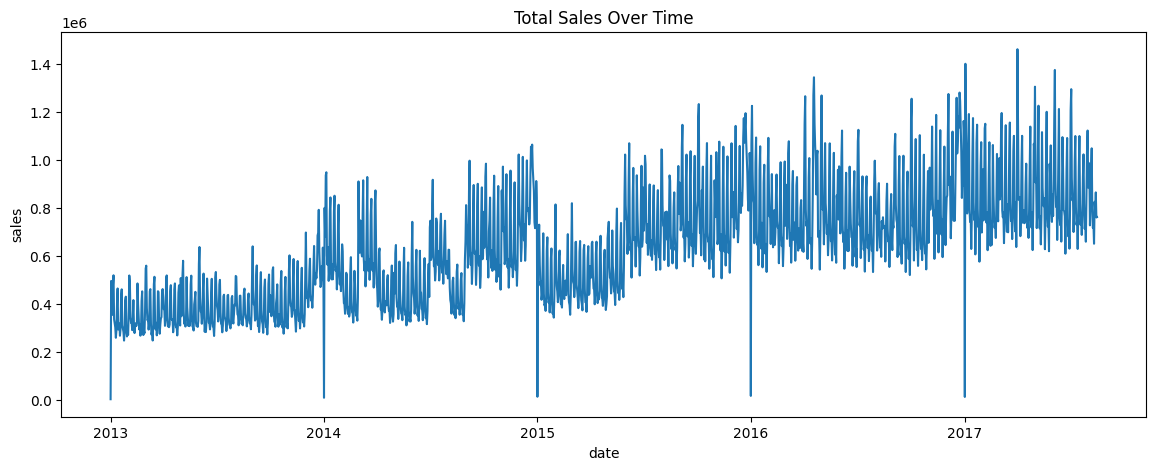

In [10]:
# Sales trend over time
plt.figure(figsize=(14,5))
sns.lineplot(data=train.groupby("date")["sales"].sum().reset_index(), x="date", y="sales")
plt.title("Total Sales Over Time")

# 4. Feature Engineering

Added:
<li> Calendar features (day, month, weekend)
<li> Merge store info
<li> Merge oil & holiday as exogenous variables

In [11]:
# Load additional datasets
stores = pd.read_csv("store_sales/stores.csv")
oil = pd.read_csv("store_sales/oil.csv", parse_dates=["date"])
holidays = pd.read_csv("store_sales/holidays_events.csv", parse_dates=["date"])

# Merge store info
df = train.merge(stores, on='store_nbr', how='left')

# Add date features
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Merge oil
df = df.merge(oil, on='date', how='left')
df = df.rename(columns={'dcoilwtico': 'oil_price'})

# Optional: handle oil_price NaNs
df['oil_price'] = df['oil_price'].interpolate(method='linear')

# Merge holiday: only use local or national holidays
holidays = holidays[(holidays['locale'] == 'National') | (holidays['locale'] == 'Local')]
df = df.merge(holidays[['date', 'type', 'locale_name']], on='date', how='left')
df['is_holiday'] = df['type_y'].notna().astype(int)

# 5. Prophet Forcasting (Binary & Families)

For Propeth Only process 1 store because of crash runtime
* On this case I Only Show Groceries 1 In Store 1

In [12]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Filtering 1 Store 1 Family
store = 1
family = 'GROCERY I'
subset = df[(df['store_nbr'] == store) & (df['family'] == family)]

df_prophet = subset[['date', 'sales', 'oil_price']].rename(columns={
    'date': 'ds',
    'sales': 'y'
})

# Drop NaN Data
df_prophet = df_prophet.dropna(subset=['ds', 'y', 'oil_price'])

# Make model and Add regressor
model = Prophet()
model.add_regressor('oil_price')
model.fit(df_prophet)

# Future Data
future = model.make_future_dataframe(periods=30)
oil_future = oil.rename(columns={'date': 'ds', 'dcoilwtico': 'oil_price'})
future = future.merge(oil_future, on='ds', how='left')
future['oil_price'] = future['oil_price'].interpolate(method='linear')

# Prediction
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmparu2en6x/4gcntdjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmparu2en6x/s6ofs4hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78566', 'data', 'file=/tmp/tmparu2en6x/4gcntdjq.json', 'init=/tmp/tmparu2en6x/s6ofs4hl.json', 'output', 'file=/tmp/tmparu2en6x/prophet_model3it1ykfd/prophet_model-20250730035933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:59:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:59:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Sample Historis Data

In [13]:
print("Sample Data Historis:")
df_display = df_prophet.rename(columns={
    'ds': 'Date',
    'y': 'Sales',
    'oil_price': 'Oil Price'
})
df_display.sample(10)

Sample Data Historis:


,Date,Sales,Oil Price
1345422,2015-01-19,2554.0,47.352745
374232,2013-07-27,1768.0,104.759453
1388190,2015-02-12,2193.0,51.170000
372450,2013-07-26,1912.0,104.760000
65946,2013-02-07,1474.0,95.840000
147918,2013-03-25,1918.0,94.550000
281568,2013-06-07,2144.0,96.110000
1928136,2015-12-10,3693.0,36.760000
62382,2013-02-05,1868.0,96.680000
2245332,2016-05-31,3496.0,49.100000


### Plot

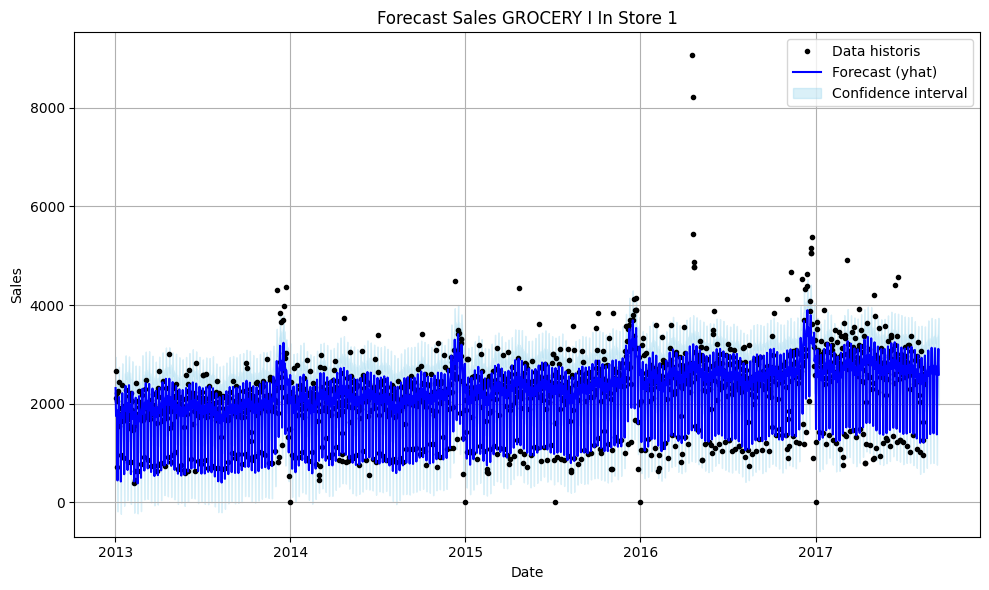

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], 'k.', label='Data historis')
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast (yhat)')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='skyblue', alpha=0.3, label='Confidence interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Forecast Sales {family} In Store {store}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis Performance

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Gabungkan hasil forecast dan data aktual
merged = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')

# Hitung error
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 282.64
RMSE: 482.91


In [20]:
df_prophet['y'].describe()

,y
count,1708.000000
mean,2226.771663
std,783.618497
min,0.000000
25%,1873.500000
50%,2285.000000
75%,2652.000000
max,9065.000000


### Seasoning Plot

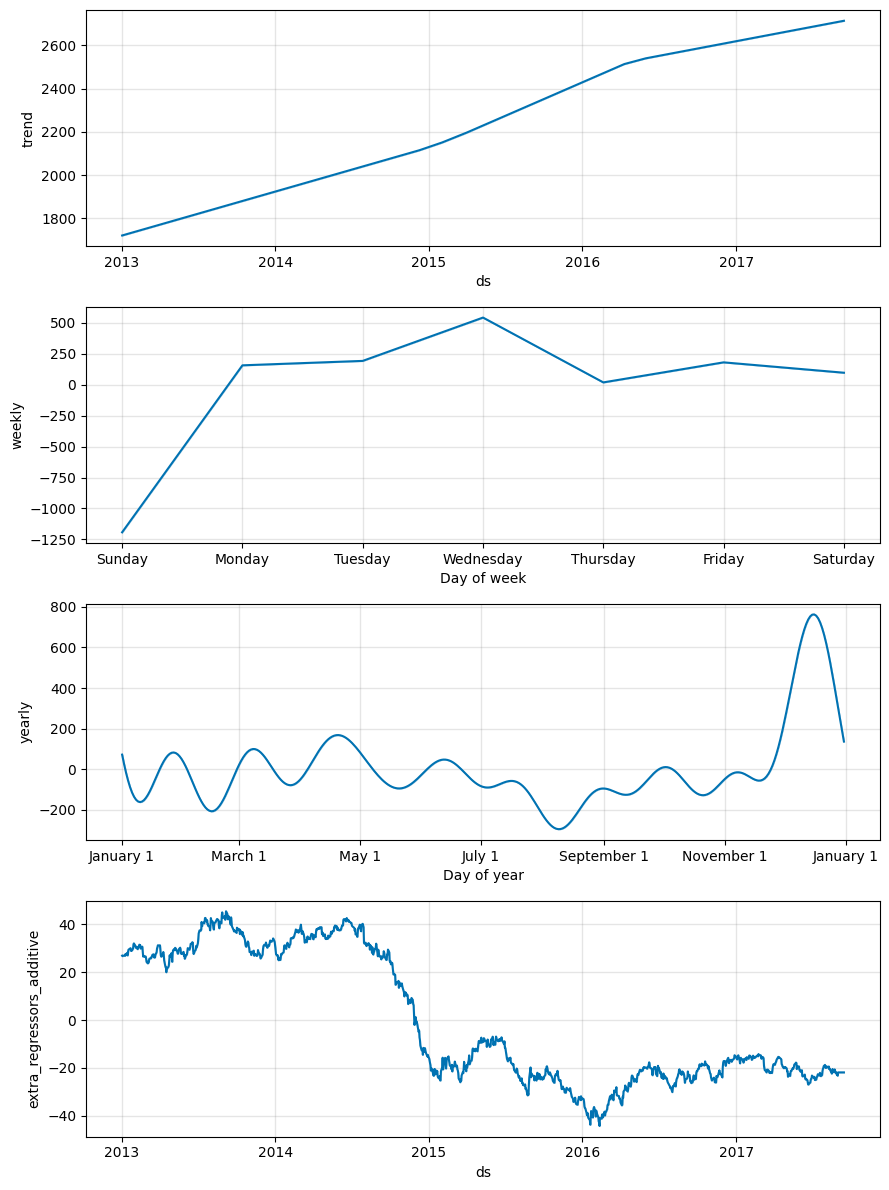

In [21]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()

### Residual Analitycs

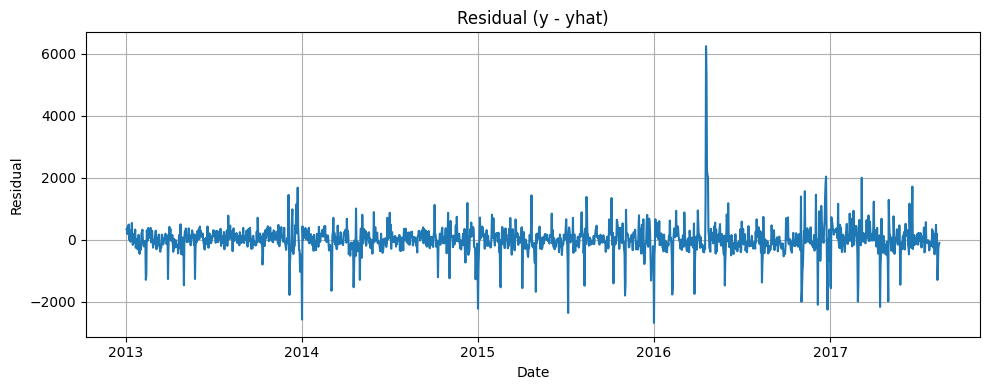

In [22]:
residuals = merged['y'] - merged['yhat']
plt.figure(figsize=(10, 4))
plt.plot(merged['ds'], residuals)
plt.title('Residual (y - yhat)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

### Report to CSV

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_result.csv', index=False)

# Sumary

The Prophet sales forecasting model was successfully applied to data from the GROCERY I family at store number 1. Based on 1,708 historical observations, the average daily sales were recorded at 2,226.77, with a minimum value of 0 and a maximum of 9,065. The data distribution showed a median of 2,285, with a standard deviation of approximately 783.62, indicating significant daily sales variation.

After training the Prophet model with the additional external variable of oil price (oil_price) as a regressor, the model was able to predict sales with a reasonable error rate. The Mean Absolute Error (MAE) of 282.64 indicates the average absolute deviation of the prediction from the actual value. The Root Mean Squared Error (RMSE) of 482.91 indicates some extreme deviations, but generally remains within acceptable limits given the large data scale.

Overall, the Prophet model is quite reliable in capturing sales trends and seasonal patterns, and can be used as an initial basis for making inventory planning or future sales strategies.